In this notebook, we'll explore the essential concepts of data loading in PyTorch.  Efficient data handling is crucial for training deep learning models, especially when working with large datasets. PyTorch's **DataLoader** facilitates this by enabling easy loading, batching, shuffling, and parallel processing of data.

# Import Dependencies

In [122]:
import os
import PIL
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split


import torch
import torchvision

import warnings
warnings.filterwarnings("ignore")

# Visualization Utility

In [3]:
!pip install torchshow -q

In [4]:
import torchshow as ts

In [147]:
def visualize_samples(images, labels, class_names = None,num_samples = 5):

    plt.figure(figsize = (10,5))

    for i in range(num_samples):

        plt.subplot(1,num_samples, i+1)

        image = (images[i] * (0.5)) + (0.5) #denormalize
        label = labels[i].item()

        plt.imshow(image.permute(1,2,0) )
        title = f"Label: {label}"

        if class_names:
           title = f"Label: {class_names[label]}"

        plt.title(title)
        plt.axis('off')
    plt.show()


# Using Torchvision Datasets

PyTorch’s `torchvision.datasets` offers ready-to-use datasets like MNIST, CIFAR-10, and ImageNet. These are pre-packaged with standard training and test splits, and often come with labels, making them ideal for quick experiments.

In [148]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader


common_transform = transforms.Compose([
    transforms.ToTensor(),  # Convert PIL images to PyTorch tensors
    transforms.Normalize((0.5,), (0.5,))  # Normalize the images to have mean 0.5 and std 0.5
])

mnist_train_set = datasets.CIFAR10(root=".", download = True, train = True, transform = common_transform)
mnist_val_set = datasets.CIFAR10(root=".", download = True, train = False, transform = common_transform)

mnist_train_loader = DataLoader(mnist_train_set, batch_size = 16, shuffle = True)
mnist_val_loader = DataLoader(mnist_val_set, batch_size = 16, shuffle = False)

print(len(mnist_train_set))

Files already downloaded and verified
Files already downloaded and verified
50000


In [106]:
cifar10_classes = {
    0: "airplane",
    1: "automobile",
    2: "bird",
    3: "cat",
    4: "deer",
    5: "dog",
    6: "frog",
    7: "horse",
    8: "ship",
    9: "truck"
}


#sanity check
len(next(iter(mnist_train_loader)))

2

Images shape: torch.Size([16, 3, 32, 32]) ; Labels shape: torch.Size([16])


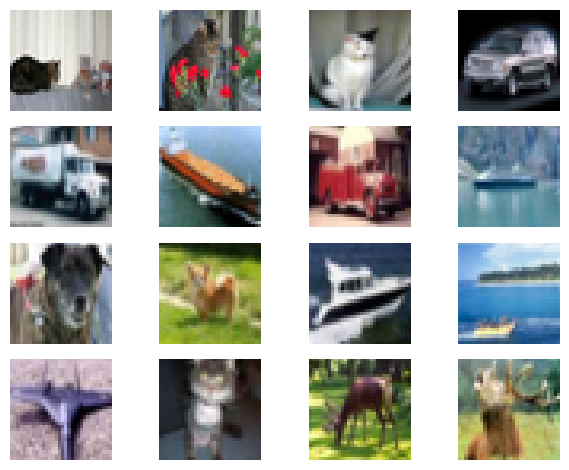

In [149]:
for images, labels in mnist_train_loader:
    print(f"Images shape: {images.shape} ; Labels shape: {labels.shape}")
    ts.show(images)
    # visualize_samples(images, labels)
    break

# Using ImageFolder

 For datasets organized into directories by class, the `datasets.ImageFolder` class provides a straightforward way to load images.



In [104]:
# !wget -q "https://www.dropbox.com/s/45jdd8padeyjq6t/10_Monkey_Species.zip?dl=1" -O "10_Monkey_Species.zip"

# !unzip -q "10_Monkey_Species.zip"

In [150]:
root = os.getcwd()

common_transform = transforms.Compose([
    transforms.Resize((48,48)),
    transforms.ToTensor(),  # Convert PIL images to PyTorch tensors
    transforms.Normalize((0.5,), (0.5,))  # Normalize the images to have mean 0.5 and std 0.5
])

train_root = os.path.join("10_Monkey_Species", "training", "training")
val_root = os.path.join(root, "10_Monkey_Species", "validation", "validation")

In [151]:
train_dataset = datasets.ImageFolder(root = train_root, transform = common_transform)
val_dataset = datasets.ImageFolder(root = val_root, transform = common_transform)

train_loader  = DataLoader(train_dataset, batch_size = 16, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = 16, shuffle = True)

print("Len of Train Dataset", len(train_dataset))
print("Len of Val Dataset", len(val_dataset))

Len of Train Dataset 1097
Len of Val Dataset 272


In [152]:
#sanity check
len(next(iter(train_loader)))

2

Images shape: torch.Size([16, 3, 48, 48]) ; Labels shape: torch.Size([16])


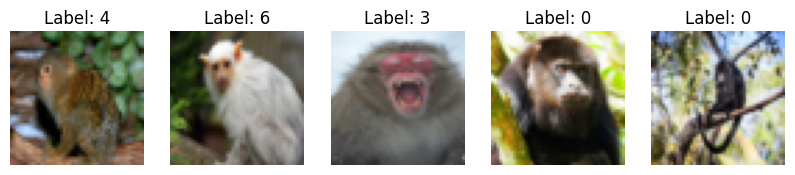

In [155]:
for images, labels in train_loader:
    print(f"Images shape: {images.shape} ; Labels shape: {labels.shape}")
    # ts.show(images)
    visualize_samples(images, labels)
    break

# Creating Custom DataLoader

 When working with datasets that don’t fit the standard formats, we can subclass `torch.utils.data.Dataset` to create a custom dataset. This method offers flexibility, allowing us to define how data is loaded, transformed, and accessed.

In [156]:
from torch.utils.data import Dataset

os.makedirs("FER2013", exist_ok=True)

In [157]:
# !wget -q "https://www.dropbox.com/scl/fi/6171214eg2qmrahw1ijvw/FER2013.zip?rlkey=hjd7kj1vt015r0yusfuihbfa6&st=y8bur912&dl=1" -O FER2013.zip

# !unzip -q  FER2013.zip

replace fer2013/fer2013.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [125]:
!sudo apt-get install tree -y > /dev/null 2>&1

In [126]:
!tree "./fer2013"

./fer2013
├── fer2013.bib
├── fer2013.csv
├── README
├── test.csv
└── train.csv

0 directories, 5 files


In [158]:
# Load the dataset
csv_file = 'fer2013/train.csv'
df = pd.read_csv(csv_file)

# Split the dataset into training and validation sets
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# Print the sizes of the datasets
print(f"Train size: {len(train_df)}, Validation size: {len(val_df)}")

Train size: 22967, Validation size: 5742


In [159]:
class FER2013Dataset(Dataset):
    def __init__(self, data_frame, transform=None):
        """
        Parameters:
        - data_frame (pd.DataFrame): A DataFrame containing the dataset with columns for pixels and emotions.
        - transform (callable, optional): Optional transform to be applied on an image sample.
        """

        self.data_frame = data_frame  # Store the DataFrame containing the dataset
        self.transform = transform    # Store any transformations to be applied to the images

    def __len__(self):
        """
        Returns:
        - int: The length of the dataset (number of samples).
        """

        return len(self.data_frame)

    def __getitem__(self, idx):
        """
        Parameters:
        - idx (int or list): Index of the sample to be retrieved. If it's a tensor, convert it to a list.

        Returns:
        - image (PIL.Image or Tensor): The processed image.
        - label (int): The label corresponding to the image.
        """

        if torch.is_tensor(idx):
            idx = idx.tolist()  # Convert tensor index to a list if necessary

        # Retrieve the sample from the DataFrame based on the index
        sample = self.data_frame.iloc[idx]

        # Convert the 'pixels' column from a string of space-separated numbers to a numpy array
        image = np.array(sample['pixels'].split(), dtype=np.uint8).reshape(48, 48)

        # Retrieve the label from the 'emotion' column and convert it to an integer label
        label = int(sample['emotion'])

        # Convert the numpy array image to a PIL Image and convert to RGB by repeating channels
        image = PIL.Image.fromarray(image).convert('RGB')

        # Apply any transformations to the image if provided
        if self.transform:
            image = self.transform(image)

        # Return the transformed image and corresponding label
        return image, label


In [160]:
# Create datasets
train_dataset = FER2013Dataset(data_frame=train_df, transform=common_transform)
val_dataset = FER2013Dataset(data_frame=val_df, transform=common_transform)

train_loader  = DataLoader(train_dataset, batch_size = 16, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = 16, shuffle = True)

print("Number of Samples in Train Dataset:", len(train_dataset))
print("Number of Samples in Validation Dataset:", len(val_dataset))

Number of Samples in Train Dataset: 22967
Number of Samples in Validation Dataset: 5742


In [161]:
#sanity check
len(next(iter(train_loader)))

2

In [165]:
class_mapping = {
    0: "Angry",
    1: "Disgust",
    2: "Fear",
    3: "Happy",
    4: "Sad",
    5: "Surprise",
    6: "Neutral"
}

Images shape: torch.Size([16, 3, 48, 48]) ; Labels shape: torch.Size([16])


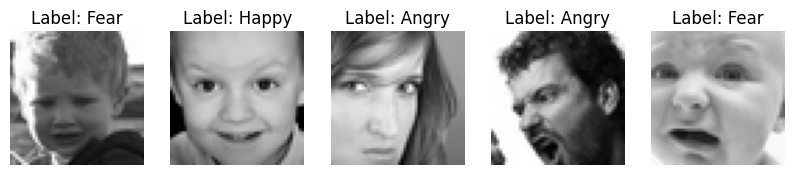

In [166]:
for images, labels in train_loader:
    print(f"Images shape: {images.shape} ; Labels shape: {labels.shape}")
    # ts.show(images)
    visualize_samples(images, labels, class_mapping)
    break